In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import io
import py7zr

from prediction_ML_pipeline import extract_info_from_filename, add_date_ticker, data_preprocessing
from order_imbalance import iceberg_tag

In [2]:
# Group by 5 minute bucket
# Calculate mean hidden order execution


def mean_analysis(ticker, calc_type='mean', year=2018, delta='10min'):
    
    df_4_resampled_lst = []
    df_5_resampled_lst = []


    archive_path = f"/nfs/data/lobster_data/lobster_raw/2017-19/_data_dwn_32_302__{ticker}_{year}-01-01_{year}-12-31_10.7z"
    with py7zr.SevenZipFile(archive_path, mode='r') as archive:
        filenames = archive.getnames()
        orderbook_files = [f for f in filenames if 'orderbook' in f]
        message_files = [f for f in filenames if 'message' in f]
        # Process matching orderbook and message files
        for orderbook_file, message_file in zip(orderbook_files, message_files):
            extracted_files = archive.read([orderbook_file, message_file])
            orderbook_stream = io.BytesIO(extracted_files[orderbook_file].read())
            message_stream = io.BytesIO(extracted_files[message_file].read())
            print("Processed files:", orderbook_file, message_file, flush=True)

            orderbook_chunk = pd.read_csv(orderbook_stream, header=None, usecols=[0, 1, 2, 3])
            message_chunk = pd.read_csv(message_stream, header=None, usecols=[0, 1, 2, 3, 4, 5])
            ticker, date = extract_info_from_filename(message_file)

            message_chunk = add_date_ticker(message_chunk, date, ticker)

            message_chunk, orderbook_chunk = data_preprocessing(message_chunk, orderbook_chunk, ticker_name=ticker,
                                                                start_time="9:30:00", end_time='4:00:00')
            
            df_4 = iceberg_tag(message_chunk, ib_delta='1ms')
            df_5 = message_chunk[message_chunk['event_type'] == 5]

            if calc_type == 'mean':
                df_4_resampled = df_4['size'].resample(delta, level='datetime').mean()
                df_5_resampled = df_5['size'].resample(delta, level='datetime').mean()
            elif calc_type == 'agg':
                df_4_resampled = df_4['size'].resample(delta, level='datetime').sum()
                df_5_resampled = df_5['size'].resample(delta, level='datetime').sum()

            df_4_resampled_lst.append(df_4_resampled)
            df_5_resampled_lst.append(df_5_resampled)

        df_4_full = pd.concat(df_4_resampled_lst)
        df_5_full = pd.concat(df_5_resampled_lst)
    
    return df_4_full, df_5_full


In [3]:
df_4_resampled, df_5_resampled = mean_analysis("RL")

Processed files: RL_2018-01-02_34200000_57600000_orderbook_10.csv RL_2018-01-02_34200000_57600000_message_10.csv


Processed files: RL_2018-01-03_34200000_57600000_orderbook_10.csv RL_2018-01-03_34200000_57600000_message_10.csv
Processed files: RL_2018-01-04_34200000_57600000_orderbook_10.csv RL_2018-01-04_34200000_57600000_message_10.csv
Processed files: RL_2018-01-05_34200000_57600000_orderbook_10.csv RL_2018-01-05_34200000_57600000_message_10.csv
Processed files: RL_2018-01-08_34200000_57600000_orderbook_10.csv RL_2018-01-08_34200000_57600000_message_10.csv
Processed files: RL_2018-01-09_34200000_57600000_orderbook_10.csv RL_2018-01-09_34200000_57600000_message_10.csv
Processed files: RL_2018-01-10_34200000_57600000_orderbook_10.csv RL_2018-01-10_34200000_57600000_message_10.csv
Processed files: RL_2018-01-11_34200000_57600000_orderbook_10.csv RL_2018-01-11_34200000_57600000_message_10.csv
Processed files: RL_2018-01-12_34200000_57600000_orderbook_10.csv RL_2018-01-12_34200000_57600000_message_10.csv
Processed files: RL_2018-01-16_34200000_57600000_orderbook_10.csv RL_2018-01-16_34200000_5760000

In [4]:
df_4_resampled_sum, df_5_resampled_sum = mean_analysis("RL", 'agg')

Processed files: RL_2018-01-02_34200000_57600000_orderbook_10.csv RL_2018-01-02_34200000_57600000_message_10.csv


Processed files: RL_2018-01-03_34200000_57600000_orderbook_10.csv RL_2018-01-03_34200000_57600000_message_10.csv
Processed files: RL_2018-01-04_34200000_57600000_orderbook_10.csv RL_2018-01-04_34200000_57600000_message_10.csv
Processed files: RL_2018-01-05_34200000_57600000_orderbook_10.csv RL_2018-01-05_34200000_57600000_message_10.csv
Processed files: RL_2018-01-08_34200000_57600000_orderbook_10.csv RL_2018-01-08_34200000_57600000_message_10.csv
Processed files: RL_2018-01-09_34200000_57600000_orderbook_10.csv RL_2018-01-09_34200000_57600000_message_10.csv
Processed files: RL_2018-01-10_34200000_57600000_orderbook_10.csv RL_2018-01-10_34200000_57600000_message_10.csv
Processed files: RL_2018-01-11_34200000_57600000_orderbook_10.csv RL_2018-01-11_34200000_57600000_message_10.csv
Processed files: RL_2018-01-12_34200000_57600000_orderbook_10.csv RL_2018-01-12_34200000_57600000_message_10.csv
Processed files: RL_2018-01-16_34200000_57600000_orderbook_10.csv RL_2018-01-16_34200000_5760000

In [5]:
def process_df(df):
    df = df.to_frame()
    df.index = pd.to_datetime(df.index)
    df['time'] = df.index.time
    df['month'] = df.index.month

    return df

In [6]:
df_4_resampled = process_df(df_4_resampled)
df_5_resampled = process_df(df_5_resampled)
df_4_resampled_sum = process_df(df_4_resampled_sum)
df_5_resampled_sum = process_df(df_5_resampled_sum)

In [7]:
def df_mean_std_calc(df, month=False):
    if not month:
        return df.groupby('time')['size'].agg(['mean', 'std'])
    else:
        return df.groupby(['time', 'month'])['size'].agg(['mean', 'std'])

In [8]:
def plot_mean_with_std(df):
    # Group by the 'time' column and calculate the mean and standard deviation for 'size'
    grouped_stats = df.groupby('time')['size'].agg(['mean', 'std'])
    
    # Prepare the plot
    plt.figure(figsize=(12, 6))
    
    # Plot the mean size
    plt.plot(grouped_stats.index.astype('str'), grouped_stats['mean'], label='Mean Size', color='blue')

    # Plot the standard deviation bounds
    plt.fill_between(grouped_stats.index.astype('str'),
                     grouped_stats['mean'] - 1.96 * grouped_stats['std'],
                     grouped_stats['mean'] + 1.96 * grouped_stats['std'],
                     color='blue', alpha=0.2, label='Mean with confidence int.')

    # Formatting the plot
    plt.xlabel('Time')
    plt.ylabel('Size')
    plt.title('Mean Size with Standard Deviation Bounds by Time Bucket')
    plt.xticks(rotation=45)
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

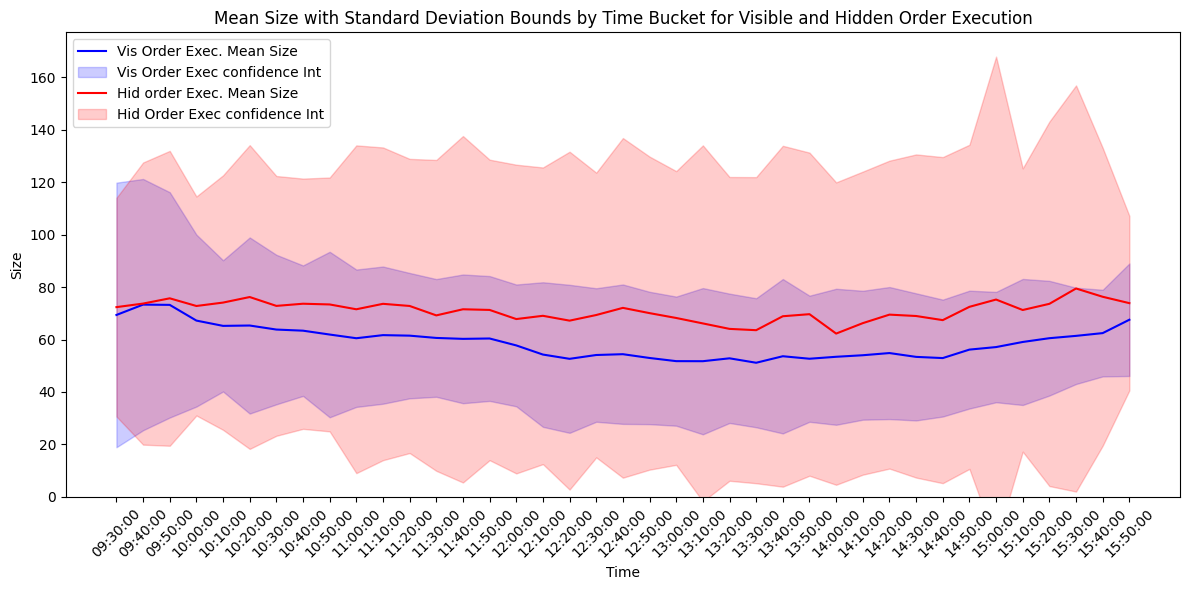

In [9]:
plt.figure(figsize=(12, 6))

df_4_stats = df_mean_std_calc(df_4_resampled)
df_5_stats = df_mean_std_calc(df_5_resampled)
    # Plot the mean size

plt.plot(df_4_stats.index.astype('str'), df_4_stats['mean'], label='Vis Order Exec. Mean Size', color='blue')

# Plot the standard deviation bounds
plt.fill_between(df_4_stats.index.astype('str'),
                    df_4_stats['mean'] - 1.96 * df_4_stats['std'],
                    df_4_stats['mean'] + 1.96 * df_4_stats['std'],
                    color='blue', alpha=0.2, label='Vis Order Exec confidence Int')


plt.plot(df_5_stats.index.astype('str'), df_5_stats['mean'], label='Hid order Exec. Mean Size', color='red')

# Plot the standard deviation bounds
plt.fill_between(df_5_stats.index.astype('str'),
                    df_5_stats['mean'] - 1.96 * df_5_stats['std'],
                    df_5_stats['mean'] + 1.96 * df_5_stats['std'],
                    color='red', alpha=0.2, label='Hid Order Exec confidence Int')

# Formatting the plot
plt.xlabel('Time')
plt.ylabel('Size')
plt.title('Mean Size with Standard Deviation Bounds by Time Bucket for Visible and Hidden Order Execution')
plt.xticks(rotation=45)
plt.legend()
plt.ylim(bottom=0)
# Show the plot
plt.tight_layout()
plt.show()


In [14]:
hid_vis_size_ratio = df_5_resampled_sum['size'] / df_4_resampled_sum['size']
hid_vis_size_ratio = hid_vis_size_ratio.to_frame()
hid_vis_size_ratio['time'] = hid_vis_size_ratio.index.time

hid_vis_size_ratio = df_mean_std_calc(hid_vis_size_ratio, month=False)

<Figure size 1200x600 with 0 Axes>

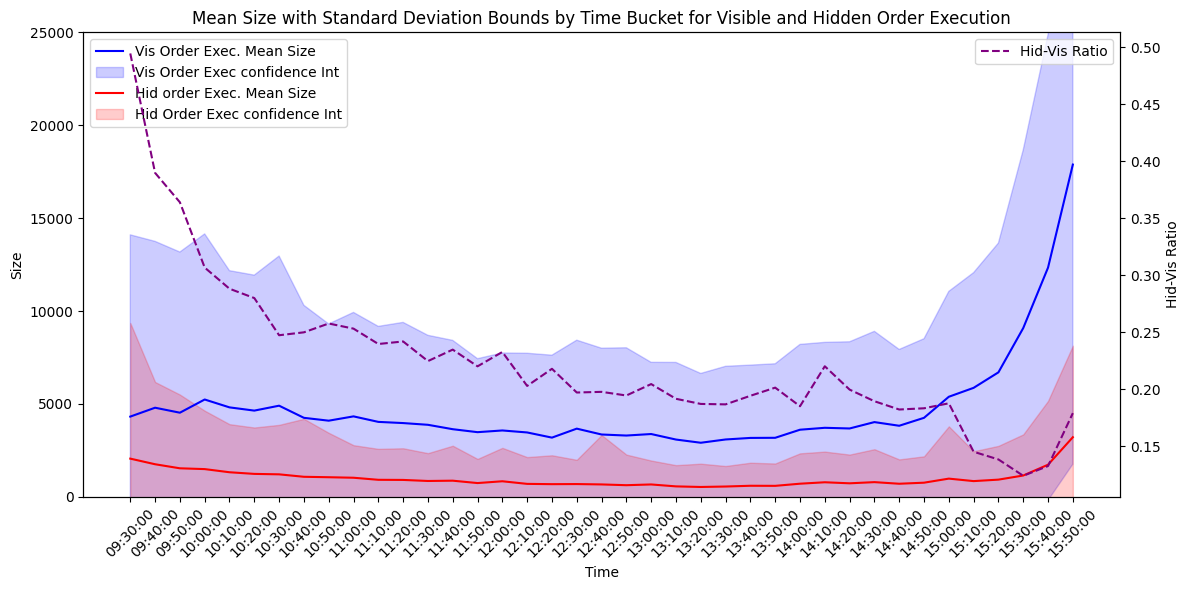

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Calculate statistics
df_4_stats = df_mean_std_calc(df_4_resampled_sum)
df_5_stats = df_mean_std_calc(df_5_resampled_sum)

# Create the primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot on the primary axis
ax1.plot(df_4_stats.index.astype('str'), df_4_stats['mean'], label='Vis Order Exec. Mean Size', color='blue')
ax1.fill_between(df_4_stats.index.astype('str'),
                 df_4_stats['mean'] - 1.96 * df_4_stats['std'],
                 df_4_stats['mean'] + 1.96 * df_4_stats['std'],
                 color='blue', alpha=0.2, label='Vis Order Exec confidence Int')

ax1.plot(df_5_stats.index.astype('str'), df_5_stats['mean'], label='Hid order Exec. Mean Size', color='red')
ax1.fill_between(df_5_stats.index.astype('str'),
                 df_5_stats['mean'] - 1.96 * df_5_stats['std'],
                 df_5_stats['mean'] + 1.96 * df_5_stats['std'],
                 color='red', alpha=0.2, label='Hid Order Exec confidence Int')

# Set labels for the primary y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Size')
ax1.set_title('Mean Size with Standard Deviation Bounds by Time Bucket for Visible and Hidden Order Execution')
ax1.set_ylim([0, 25000])
ax1.legend(loc='upper left')

# Rotate the x-ticks by 45 degrees
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the ratio on the secondary y-axis
ax2.plot(hid_vis_size_ratio.index.astype('str'), hid_vis_size_ratio['mean'], color='purple', linestyle='dashed',
         label="Hid-Vis Ratio")

# Set labels for the secondary y-axis
ax2.set_ylabel('Hid-Vis Ratio')
ax2.legend(loc='upper right')

# Rotate the x-ticks by 45 degrees for the secondary axis as well
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# Formatting the plot
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
df_4_resampled['month'] = df_4_resampled.index.month
df_5_resampled['month'] = df_5_resampled.index.month
df_4_resampled_sum['month'] = df_4_resampled_sum.index.month
df_5_resampled_sum['month'] = df_5_resampled_sum.index.month

In [ ]:
df_4_stats = df_mean_std_calc(df_4_resampled, month=True)
df_5_stats = df_mean_std_calc(df_5_resampled, month=True)

df_4_stats_sum = df_mean_std_calc(df_4_resampled_sum, month=True)
df_5_stats_sum = df_mean_std_calc(df_5_resampled_sum, month=True)

In [ ]:
month_lst = ['Jan', 'Feb', 'Mar', 'Apr', 'May', "Jun", "Jul", "Aug", "Sep", 'Oct', "Nov", "Dec"]

In [ ]:
def plot_monthly_mean_with_std(df):
    # Ensure time is in string format for better plotting
    df.index = df.index.set_levels([df.index.levels[0].astype(str), df.index.levels[1]])

    # Prepare the plot
    plt.figure(figsize=(14, 8))

    # Loop through each month and plot the mean with standard deviation bounds
    for month, month_name in zip(df.index.levels[1], month_lst):
        monthly_data = df.xs(month, level='month')
        
        # Plot the mean line
        plt.plot(monthly_data.index, monthly_data['mean'], label=f'{month_name}')
        
        # Plot the standard deviation bounds
        plt.fill_between(monthly_data.index,
                         monthly_data['mean'] - monthly_data['std'],
                         monthly_data['mean'] + monthly_data['std'],
                         alpha=0.2)

    # Formatting the plot
    plt.xlabel('Time')
    plt.ylabel('Size', fontsize=15)
    plt.xticks(rotation=45, size=12)
    plt.legend(title='Month')
    plt.ylim(bottom=0)
    
    # Show the plot
    plt.tight_layout()


Text(0.5, 1.0, 'Vis Order Exec Mean Total Size with Standard Deviation by Time Bucket and Month')

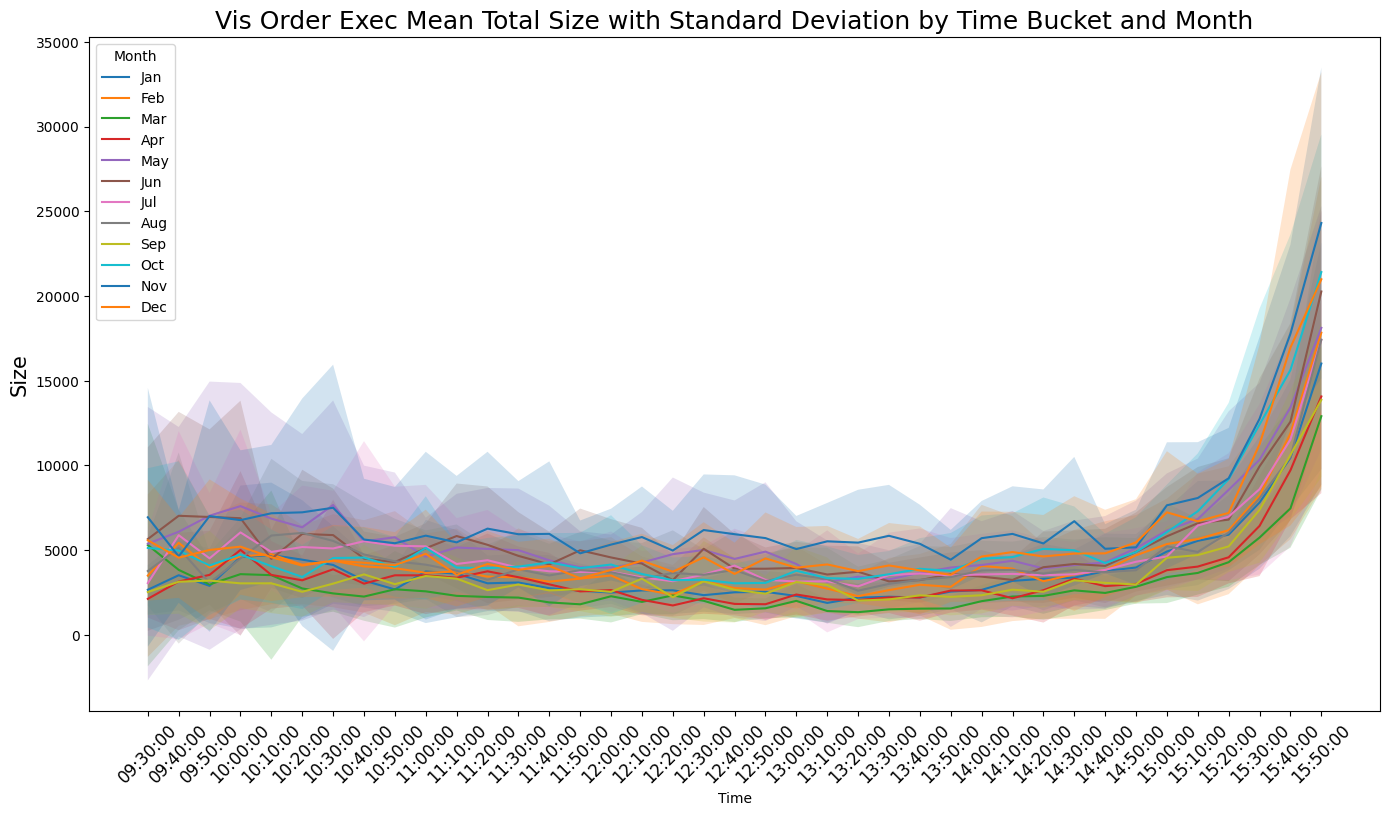

In [ ]:
plot_monthly_mean_with_std(df_4_stats_sum)
plt.title('Vis Order Exec Mean Total Size with Standard Deviation by Time Bucket and Month', fontsize=18)


Text(0.5, 1.0, 'Vis Order Exec Mean Size with Standard Deviation by Time Bucket and Month')

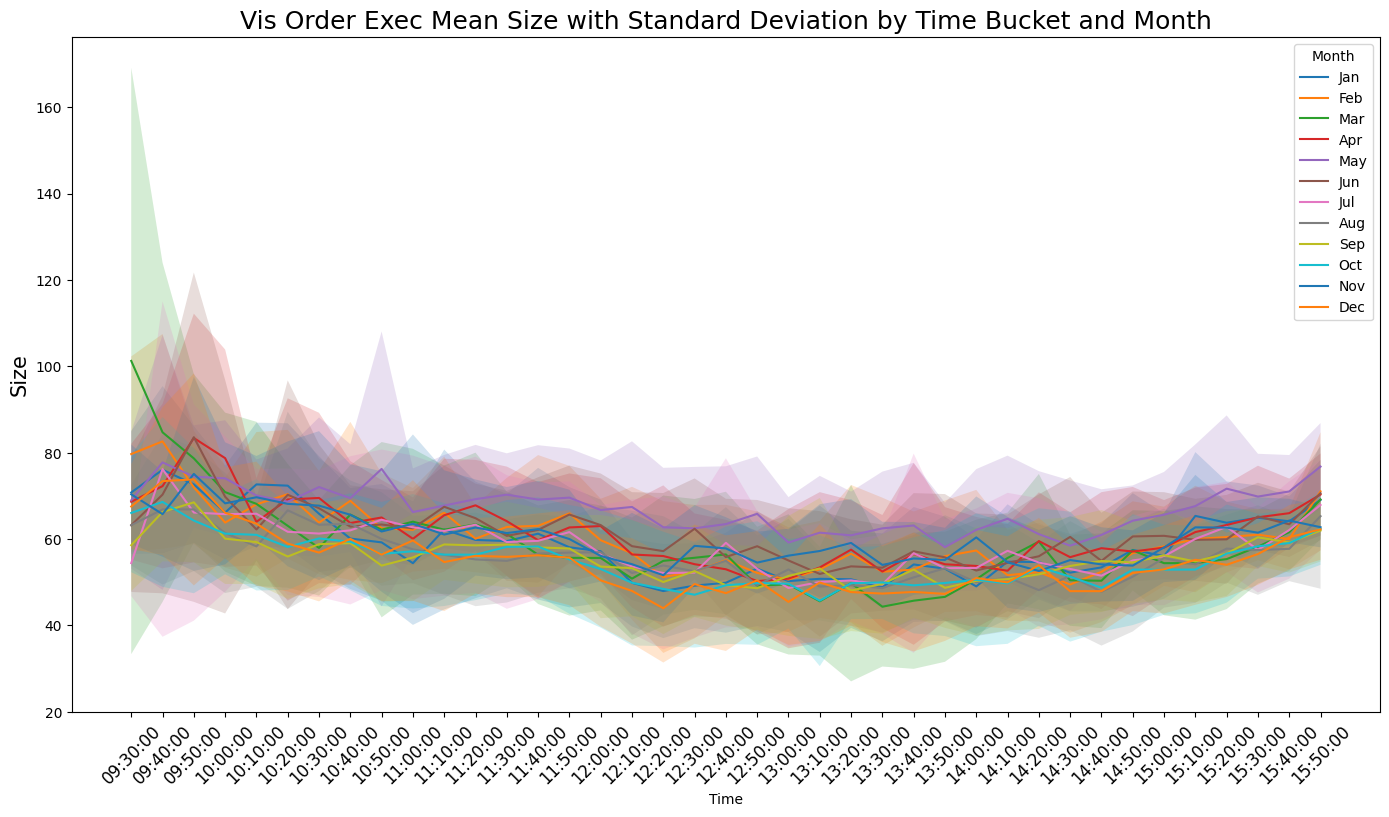

In [ ]:
plot_monthly_mean_with_std(df_4_stats)
plt.title('Vis Order Exec Mean Size with Standard Deviation by Time Bucket and Month', fontsize=18)

Text(0.5, 1.0, 'Hid Order Exec Mean Total Size with Standard Deviation by Time Bucket and Month')

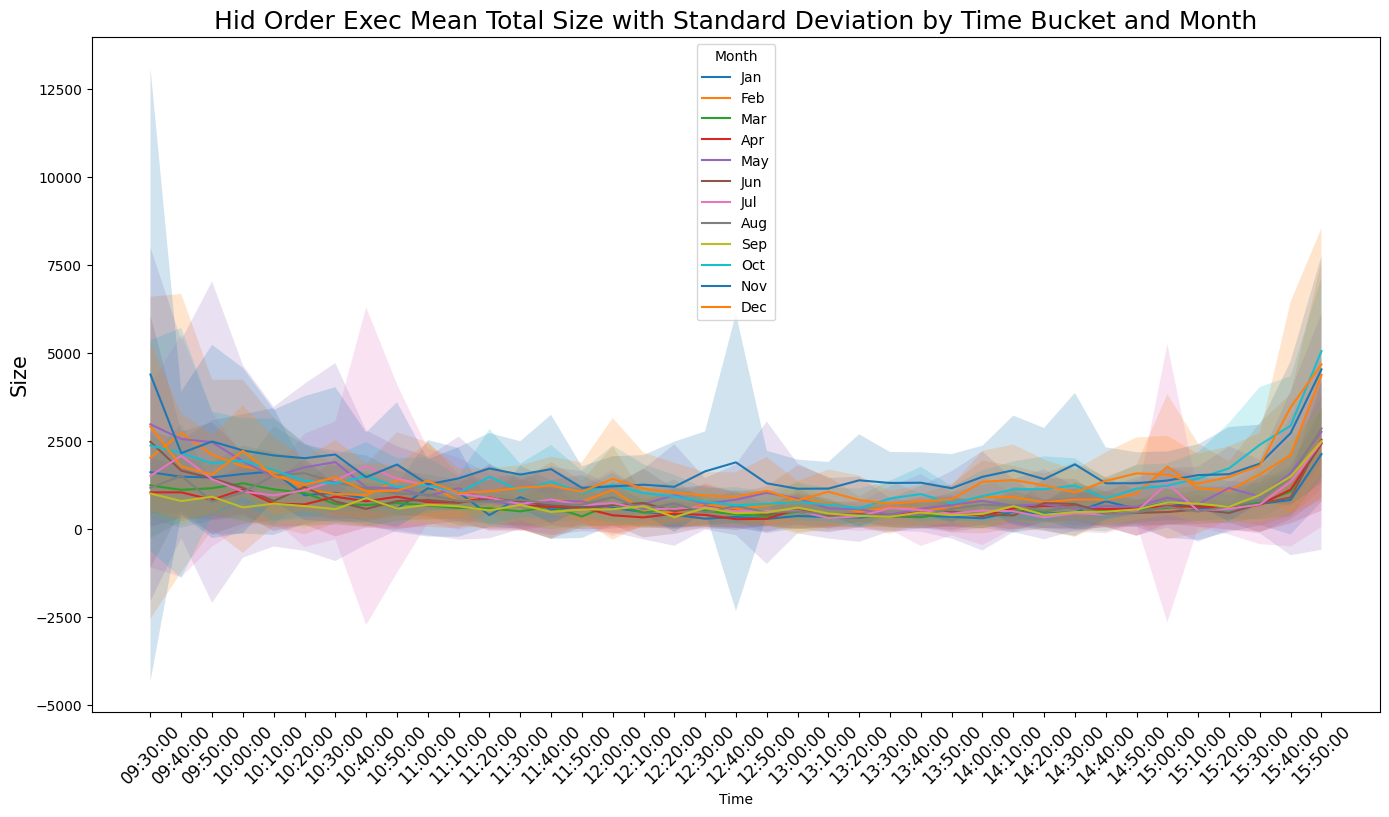

In [ ]:
plot_monthly_mean_with_std(df_5_stats_sum)
plt.title('Hid Order Exec Mean Total Size with Standard Deviation by Time Bucket and Month', fontsize=18)


Text(0.5, 1.0, 'Hid Order Exec Mean Size with Standard Deviation by Time Bucket and Month')

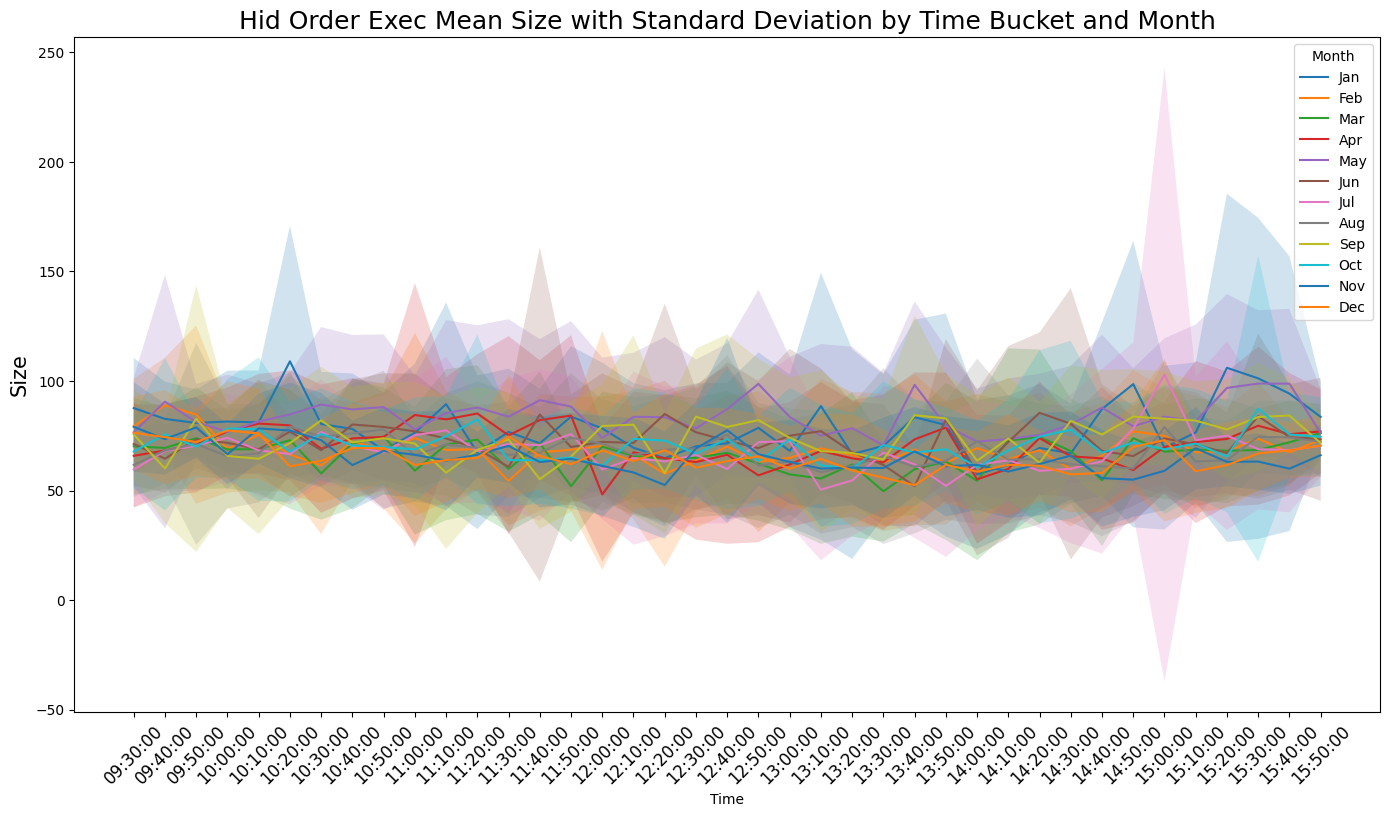

In [ ]:
plot_monthly_mean_with_std(df_5_stats)
plt.title('Hid Order Exec Mean Size with Standard Deviation by Time Bucket and Month', fontsize=18)

- Last 30 minutes bucket is very volatile
- Generally, behaviour of hidden and visible order executions are similar by month (hence we do not really need to adjust for seasonal effects)
- By first and second image, on average, the size of hidden order executions are larger than the size of visible order executions. However, the variance is also much greater than hidden order execution sizes.

# Hid-Vis Ratio

In [ ]:
hid_vis_size_ratio = df_5_resampled_sum['size'] / df_4_resampled_sum['size']
hid_vis_size_ratio = hid_vis_size_ratio.to_frame()
hid_vis_size_ratio['time'] = hid_vis_size_ratio.index.time


In [ ]:
hid_vis_size_ratio = df_mean_std_calc(hid_vis_size_ratio, month=False)